# Setting Up Project

Importing libraries for model building, selection, evaluation, and visualization.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

Load the dataset, define features and target, and split the data into training and testing sets.



In [32]:
df = pd.read_csv('/content/data_model_preprocessing-PBA.csv')

X = df.drop('Late_delivery_risk', axis=1)
y = df['Late_delivery_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Data loading and splitting complete.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data loading and splitting complete.
Shape of X_train: (85789, 30)
Shape of X_test: (36768, 30)
Shape of y_train: (85789,)
Shape of y_test: (36768,)


## Training Logistic Regression

Creating a pipeline that first scales the features using `StandardScaler` and then applies `LogisticRegression`.

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# The pipeline will first scale the data, then apply Logistic Regression
logistic_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticregression', LogisticRegression(random_state=42, solver='liblinear'))
])

print("Starting training of Logistic Regression pipeline...")
# Fit the pipeline to the training data
logistic_reg_pipeline.fit(X_train, y_train)

print("Logistic Regression pipeline training completed.")

Starting training of Logistic Regression pipeline...
Logistic Regression pipeline training completed.


Evaluating the Logistic Regression pipeline's performance on the test data (`X_test`, `y_test`).


Logistic Regression Pipeline Performance on Test Data
Accuracy: 0.9518
Precision: 0.9569
Recall: 0.9551
F1-Score: 0.9560
ROC-AUC: 0.9727

Confusion Matrix for Logistic Regression Pipeline


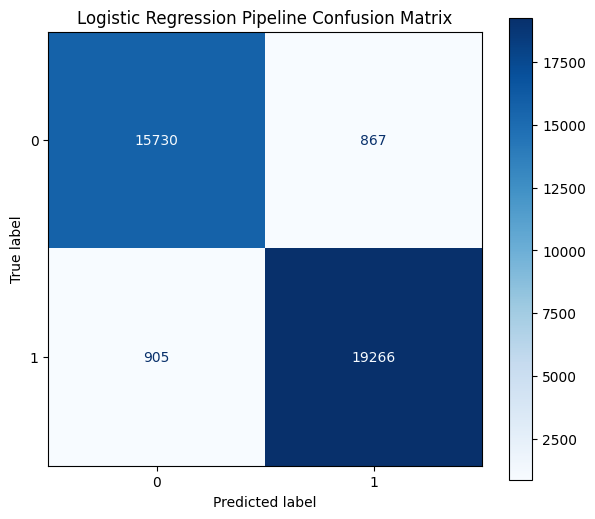

In [34]:
y_pred_logistic_reg = logistic_reg_pipeline.predict(X_test)
y_proba_logistic_reg = logistic_reg_pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class

accuracy_log_reg_pipeline = accuracy_score(y_test, y_pred_logistic_reg)
precision_log_reg_pipeline = precision_score(y_test, y_pred_logistic_reg)
recall_log_reg_pipeline = recall_score(y_test, y_pred_logistic_reg)
f1_log_reg_pipeline = f1_score(y_test, y_pred_logistic_reg)
roc_auc_log_reg_pipeline = roc_auc_score(y_test, y_proba_logistic_reg)

print("\nLogistic Regression Pipeline Performance on Test Data")
print(f"Accuracy: {accuracy_log_reg_pipeline:.4f}")
print(f"Precision: {precision_log_reg_pipeline:.4f}")
print(f"Recall: {recall_log_reg_pipeline:.4f}")
print(f"F1-Score: {f1_log_reg_pipeline:.4f}")
print(f"ROC-AUC: {roc_auc_log_reg_pipeline:.4f}")

# Generate and display the confusion matrix
print("\nConfusion Matrix for Logistic Regression Pipeline")
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay.from_estimator(logistic_reg_pipeline, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Logistic Regression Pipeline Confusion Matrix')
plt.show()

In [35]:
y_train_pred = logistic_reg_pipeline.predict(X_train)

# Compare F1-score
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_pred_logistic_reg)

print("Training F1:", f1_train)
print("Test F1:", f1_test)

Training F1: 0.9560855333078264
Test F1: 0.9560341405319571


## Learning Curves for Untuned Logistic Regression

To get the insight into how a model's performance on the training and validation sets to find out issues like underfitting or overfitting.

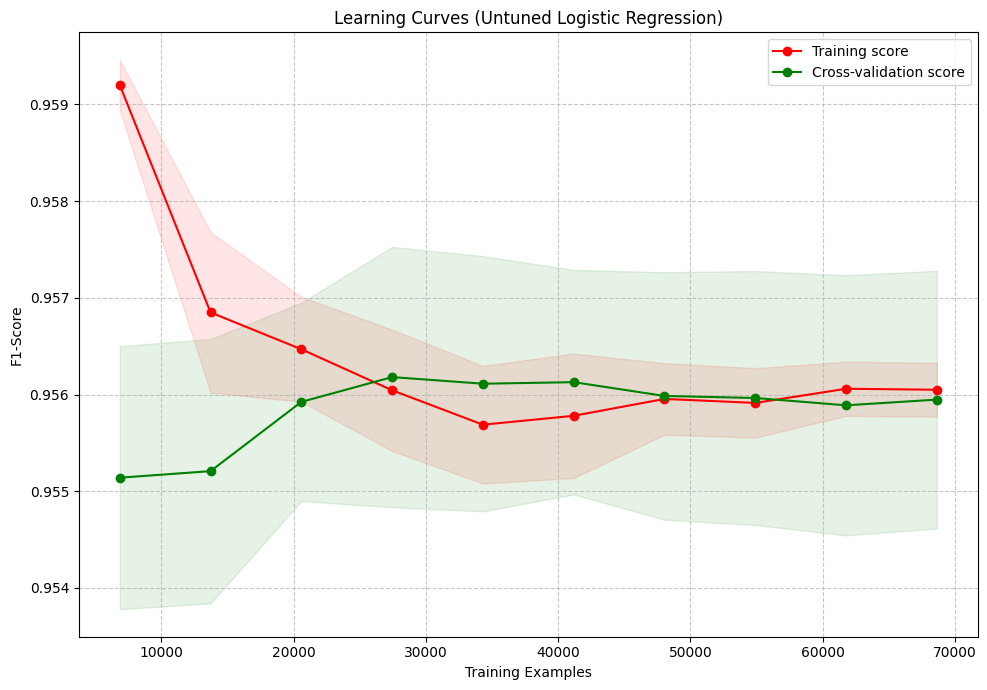

In [36]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

estimator = logistic_reg_pipeline

train_sizes, train_scores, test_scores = learning_curve(
    estimator,
    X_train, y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curves (Untuned Logistic Regression)')
plt.xlabel('Training Examples')
plt.ylabel('F1-Score')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Tuning Logistic Regression

Performing `GridSearchCV` to find the best hyperparameters for the `LogisticRegression` model, using the defined parameter grid and cross-validation on the training data.


In [37]:
logistic_reg_param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga']
}

print("Logistic Regression parameter grid defined:")
print(logistic_reg_param_grid)

Logistic Regression parameter grid defined:
{'logisticregression__C': [0.01, 0.1, 1, 10, 100], 'logisticregression__solver': ['liblinear', 'saga']}


In [38]:
print("Starting GridSearchCV for Logistic Regression...")
grid_search_logistic_reg = GridSearchCV(
    estimator=logistic_reg_pipeline,
    param_grid=logistic_reg_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to the training data
grid_search_logistic_reg.fit(X_train, y_train)

# Store the best estimator found by GridSearchCV
best_logistic_reg_model = grid_search_logistic_reg.best_estimator_

print("Logistic Regression GridSearchCV completed.")
print(f"Best parameters for Logistic Regression: {grid_search_logistic_reg.best_params_}")
print(f"Best cross-validation F1-Score for Logistic Regression: {grid_search_logistic_reg.best_score_:.4f}")
print("Best Logistic Regression model stored.")

Starting GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Logistic Regression GridSearchCV completed.
Best parameters for Logistic Regression: {'logisticregression__C': 0.1, 'logisticregression__solver': 'liblinear'}
Best cross-validation F1-Score for Logistic Regression: 0.9560
Best Logistic Regression model stored.


## Evaluate Tuned Logistic Regression Model

Evaluating the performance of the tuned Logistic Regression model on the test data using accuracy, precision, recall, F1-score, and ROC-AUC.


Evaluating Tuned Logistic Regression model...

--- Tuned Logistic Regression Pipeline Performance on Test Data ---
Accuracy: 0.9518
Precision: 0.9570
Recall: 0.9550
F1-Score: 0.9560
ROC-AUC: 0.9728

--- Confusion Matrix for Tuned Logistic Regression Pipeline ---


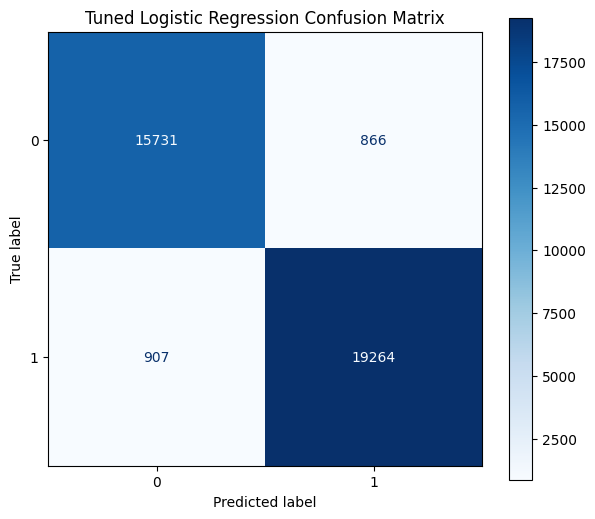

In [39]:
print("Evaluating Tuned Logistic Regression model...")

y_pred_tuned_logistic_reg = best_logistic_reg_model.predict(X_test)
y_proba_tuned_logistic_reg = best_logistic_reg_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_tuned_log_reg = accuracy_score(y_test, y_pred_tuned_logistic_reg)
precision_tuned_log_reg = precision_score(y_test, y_pred_tuned_logistic_reg)
recall_tuned_log_reg = recall_score(y_test, y_pred_tuned_logistic_reg)
f1_tuned_log_reg = f1_score(y_test, y_pred_tuned_logistic_reg)
roc_auc_tuned_log_reg = roc_auc_score(y_test, y_proba_tuned_logistic_reg)

print("\n--- Tuned Logistic Regression Pipeline Performance on Test Data ---")
print(f"Accuracy: {accuracy_tuned_log_reg:.4f}")
print(f"Precision: {precision_tuned_log_reg:.4f}")
print(f"Recall: {recall_tuned_log_reg:.4f}")
print(f"F1-Score: {f1_tuned_log_reg:.4f}")
print(f"ROC-AUC: {roc_auc_tuned_log_reg:.4f}")

# Generate and display the confusion matrix
print("\n--- Confusion Matrix for Tuned Logistic Regression Pipeline ---")
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay.from_estimator(best_logistic_reg_model, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Tuned Logistic Regression Confusion Matrix')
plt.show()

## Training an Untuned Decision Tree Classifier

First training the Decision Tree Classifier with its default parameters to establish a baseline performance to highlight the importance of hyperparameter tuning.

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

unoptimized_dt_model = DecisionTreeClassifier(random_state=42)

print("Starting training of unoptimized Decision Tree Classifier...")
# Fit the model to the training data
unoptimized_dt_model.fit(X_train, y_train)

print("Unoptimized Decision Tree Classifier training completed.")

Starting training of unoptimized Decision Tree Classifier...
Unoptimized Decision Tree Classifier training completed.


### Evaluating the Untuned Decision Tree Classifier

Now, we evaluate the performance of the unoptimized Decision Tree Classifier on the test data to understand its baseline capabilities before tuning.


Unoptimized Decision Tree Classifier Performance on Test Data
Accuracy: 0.9575
Precision: 0.9622
Recall: 0.9603
F1-Score: 0.9612
ROC-AUC: 0.9572

Confusion Matrix for Unoptimized Decision Tree Classifier


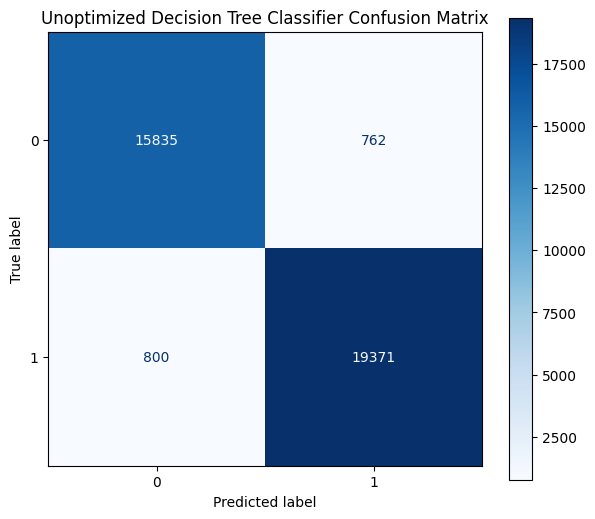

In [42]:
y_pred_unoptimized_dt = unoptimized_dt_model.predict(X_test)
y_proba_unoptimized_dt = unoptimized_dt_model.predict_proba(X_test)[:, 1] # Probability of the positive class

# Calculate evaluation metrics
accuracy_unoptimized_dt = accuracy_score(y_test, y_pred_unoptimized_dt)
precision_unoptimized_dt = precision_score(y_test, y_pred_unoptimized_dt)
recall_unoptimized_dt = recall_score(y_test, y_pred_unoptimized_dt)
f1_unoptimized_dt = f1_score(y_test, y_pred_unoptimized_dt)
roc_auc_unoptimized_dt = roc_auc_score(y_test, y_proba_unoptimized_dt)

print("\nUnoptimized Decision Tree Classifier Performance on Test Data")
print(f"Accuracy: {accuracy_unoptimized_dt:.4f}")
print(f"Precision: {precision_unoptimized_dt:.4f}")
print(f"Recall: {recall_unoptimized_dt:.4f}")
print(f"F1-Score: {f1_unoptimized_dt:.4f}")
print(f"ROC-AUC: {roc_auc_unoptimized_dt:.4f}")

print("\nConfusion Matrix for Unoptimized Decision Tree Classifier")
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay.from_estimator(unoptimized_dt_model, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Unoptimized Decision Tree Classifier Confusion Matrix')
plt.show()

In [43]:
y_train_pred = unoptimized_dt_model.predict(X_train)

# Compare F1-score
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_pred_unoptimized_dt)

print("Training F1:", f1_train)
print("Test F1:", f1_test)

Training F1: 1.0
Test F1: 0.9612445414847162


# Tuning the Decision Tree Classifier
Performing hyperparameter tuning for the Decision Tree Classifier using GridSearchCV on the training data (X_train, y_train).


In [44]:
dt_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV for Decision Tree Classifier
grid_search_dt = GridSearchCV(
    estimator=dt_classifier,
    param_grid=dt_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print("Starting GridSearchCV for Decision Tree Classifier...")
# Fit GridSearchCV to the training data
grid_search_dt.fit(X_train, y_train)

best_dt_model = grid_search_dt.best_estimator_

print("Decision Tree GridSearchCV completed.")
print(f"Best parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best cross-validation F1-Score for Decision Tree: {grid_search_dt.best_score_:.4f}")
print("Best Decision Tree model stored.")

Starting GridSearchCV for Decision Tree Classifier...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Decision Tree GridSearchCV completed.
Best parameters for Decision Tree: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 50}
Best cross-validation F1-Score for Decision Tree: 0.9582
Best Decision Tree model stored.


Evaluating the tuned Decision Tree Classifier's performance on the test data (X_test, y_test).



Decision Tree Classifier Performance on Test Data
Accuracy: 0.9557
Precision: 0.9517
Recall: 0.9685
F1-Score: 0.9600
ROC-AUC: 0.9807

Confusion Matrix for Decision Tree Classifier


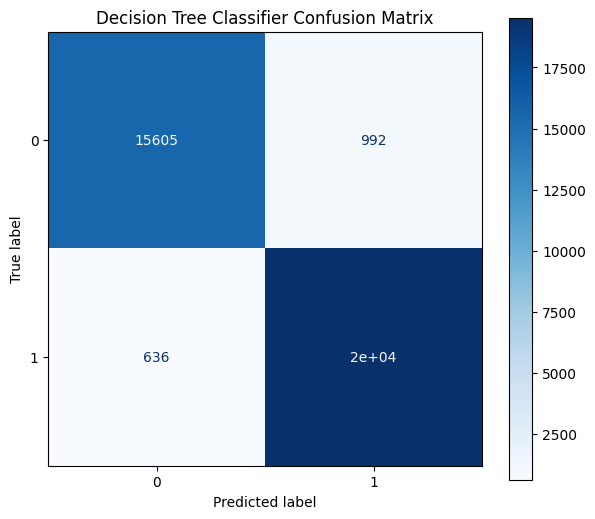

In [45]:
y_pred_dt = best_dt_model.predict(X_test)
y_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)

print("\nDecision Tree Classifier Performance on Test Data")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-Score: {f1_dt:.4f}")
print(f"ROC-AUC: {roc_auc_dt:.4f}")

print("\nConfusion Matrix for Decision Tree Classifier")
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay.from_estimator(best_dt_model, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Decision Tree Classifier Confusion Matrix')
plt.show()

In [46]:
y_opt_train_pred = best_dt_model.predict(X_train)

# Compare F1-score
f1_train = f1_score(y_train, y_opt_train_pred)
f1_test = f1_score(y_test, y_pred_dt)

print("Training F1:", f1_train)
print("Test F1:", f1_test)

Training F1: 0.9649133884784576
Test F1: 0.9599980343014399


## Feature Importance for Tuned Decision Tree Classifier

This plot visualizes the importance of each feature in the `best_dt_model` (tuned Decision Tree).

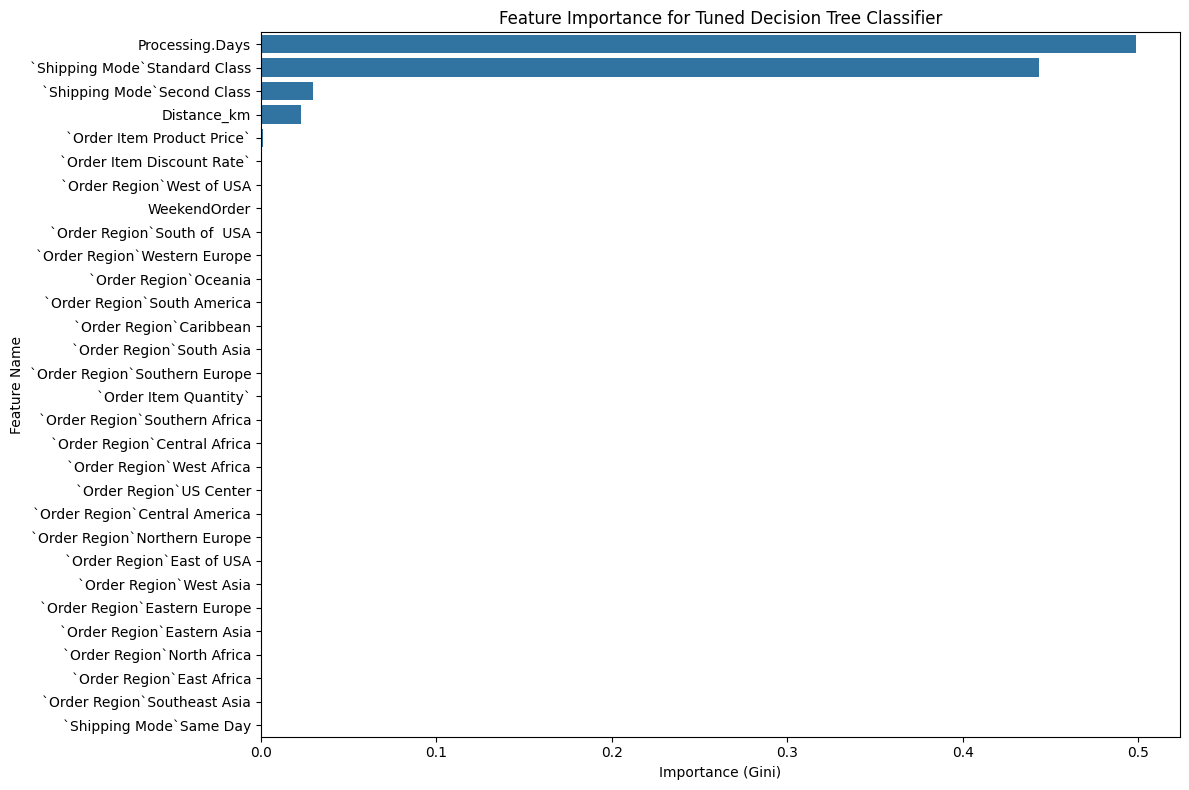

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = best_dt_model.feature_importances_
feature_names = X_train.columns

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort features by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance for Tuned Decision Tree Classifier')
plt.xlabel('Importance (Gini)')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

## Visualizations to compare the performance of both models
 This includes plotting the ROC curves for Logistic Regression and Decision Tree Classifier, and a bar chart to compare their primary evaluation metrics (accuracy, precision, recall, F1-score, ROC-AUC).


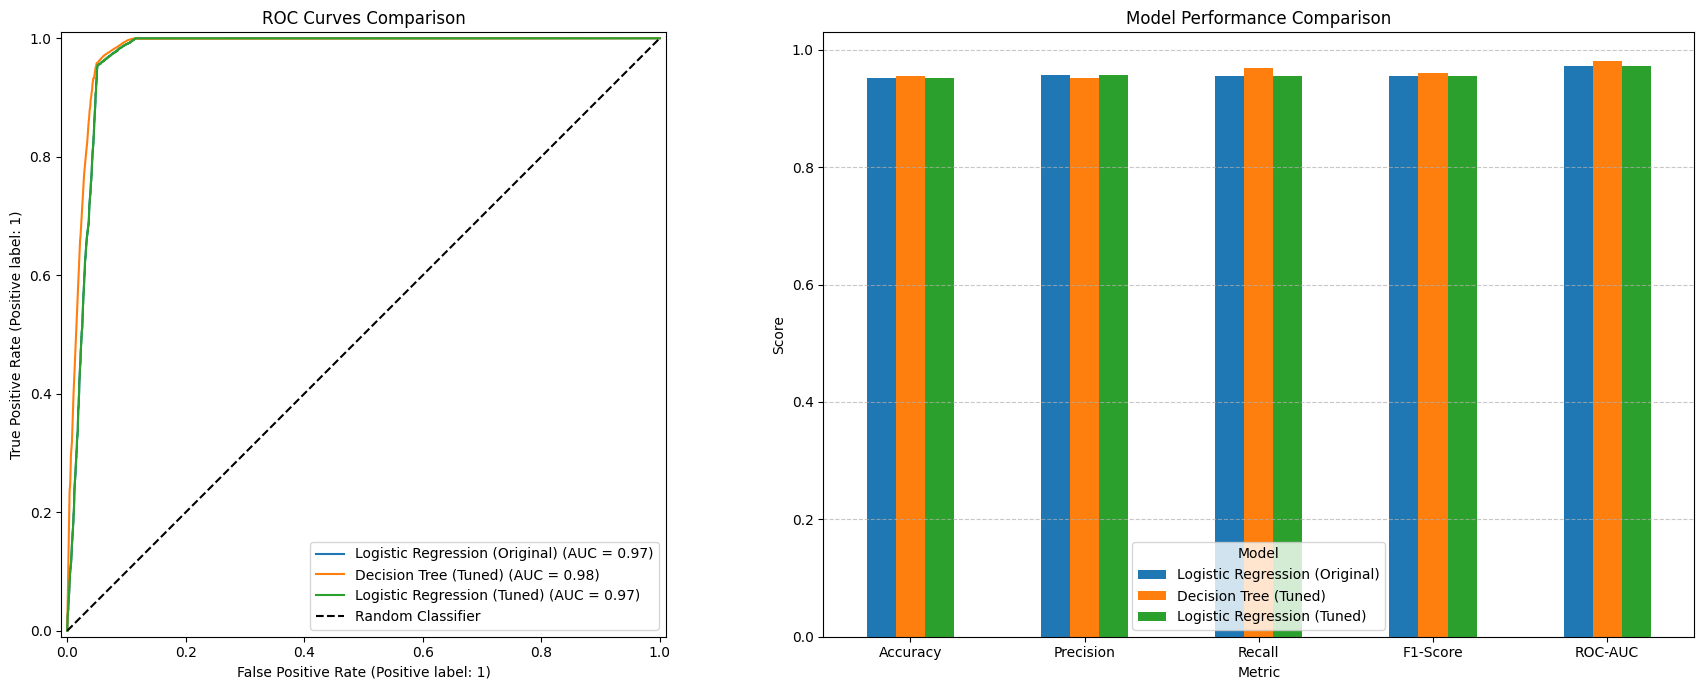

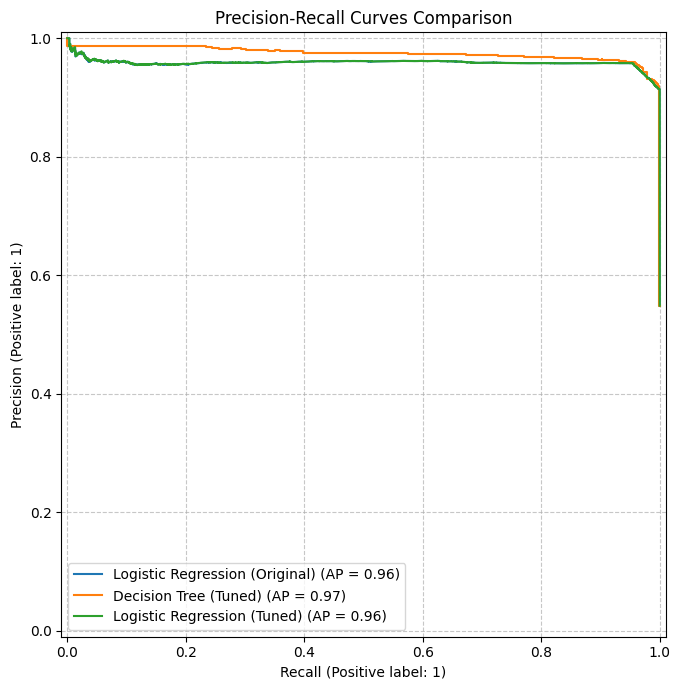

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Subplot 1: ROC Curves Comparison
# Plot ROC curve for original Logistic Regression
RocCurveDisplay.from_predictions(y_test, y_proba_logistic_reg, name='Logistic Regression (Original)', ax=axes[0])
# Plot ROC curve for Tuned Decision Tree
RocCurveDisplay.from_predictions(y_test, y_proba_dt, name='Decision Tree (Tuned)', ax=axes[0])
# Plot ROC curve for Tuned Logistic Regression
RocCurveDisplay.from_predictions(y_test, y_proba_tuned_logistic_reg, name='Logistic Regression (Tuned)', ax=axes[0])

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Add a diagonal reference line
axes[0].set_title('ROC Curves Comparison')
axes[0].legend(loc='lower right')

# Subplot 2: Model Performance Comparison Bar Chart
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Logistic Regression (Original)': [
        accuracy_log_reg_pipeline,
        precision_log_reg_pipeline,
        recall_log_reg_pipeline,
        f1_log_reg_pipeline,
        roc_auc_log_reg_pipeline
    ],
    'Decision Tree (Tuned)': [
        accuracy_dt,
        precision_dt,
        recall_dt,
        f1_dt,
        roc_auc_dt
    ],
    'Logistic Regression (Tuned)': [
        accuracy_tuned_log_reg,
        precision_tuned_log_reg,
        recall_tuned_log_reg,
        f1_tuned_log_reg,
        roc_auc_tuned_log_reg
    ]
}

metrics_df = pd.DataFrame(metrics_data).set_index('Metric')

metrics_df.plot(kind='bar', ax=axes[1], rot=0) # rot=0 to keep x-axis labels horizontal
axes[1].set_title('Model Performance Comparison')
axes[1].set_ylabel('Score')
axes[1].legend(title='Model')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- Separate Figure for Precision-Recall Curves ---
fig, ax = plt.subplots(figsize=(8, 7))

# Plot Precision-Recall curve for original Logistic Regression
PrecisionRecallDisplay.from_predictions(y_test, y_proba_logistic_reg, name='Logistic Regression (Original)', ax=ax)

# Plot Precision-Recall curve for Tuned Decision Tree
PrecisionRecallDisplay.from_predictions(y_test, y_proba_dt, name='Decision Tree (Tuned)', ax=ax)

# Plot Precision-Recall curve for Tuned Logistic Regression
PrecisionRecallDisplay.from_predictions(y_test, y_proba_tuned_logistic_reg, name='Logistic Regression (Tuned)', ax=ax)

ax.set_title('Precision-Recall Curves Comparison')
ax.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Cross-validation F1-scores extracted and combined into DataFrame.


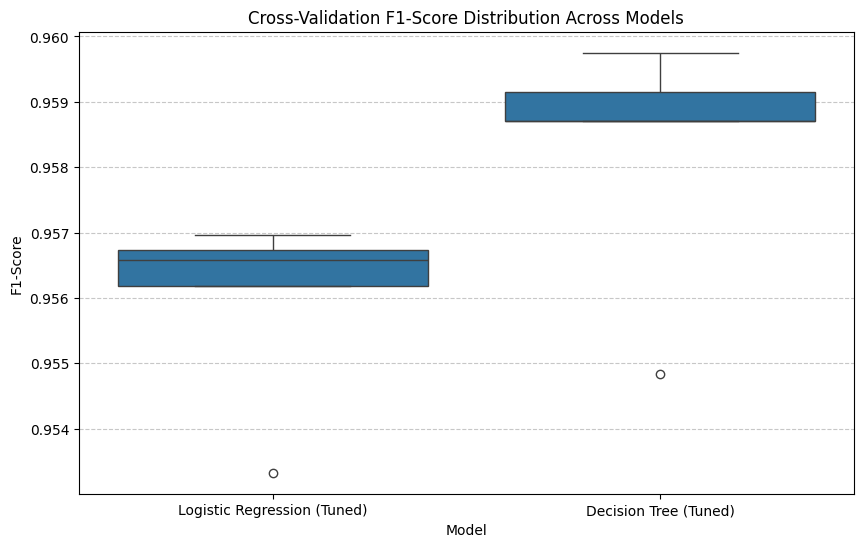

Box plot of cross-validation F1-scores displayed.


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Get cross-validation F1-scores for Tuned Logistic Regression
lr_tuned_all_folds_f1 = cross_val_score(
    best_logistic_reg_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1
)

# Get cross-validation F1-scores for Tuned Decision Tree
dt_tuned_all_folds_f1 = cross_val_score(
    best_dt_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1
)

cv_results_df = pd.DataFrame({
    'Model': ['Logistic Regression (Tuned)'] * len(lr_tuned_all_folds_f1) +
             ['Decision Tree (Tuned)'] * len(dt_tuned_all_folds_f1),
    'F1-Score': list(lr_tuned_all_folds_f1) + list(dt_tuned_all_folds_f1)
})

print("Cross-validation F1-scores extracted and combined into DataFrame.")

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='F1-Score', data=cv_results_df)
plt.title('Cross-Validation F1-Score Distribution Across Models')
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Box plot of cross-validation F1-scores displayed.")